In [2]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 134.5 kB/s eta 0:00:0000:0100:01


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]/root/miniconda3/envs/llm/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
100%|██████████| 1000/1000 [00:20<00:00, 49.82it/s]


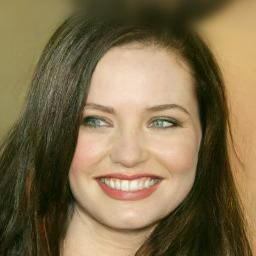

In [5]:
import torch
from diffusers import DDPMPipeline

# We can set the device to either use our GPU or use our CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pipeline
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

# Sample an image
image_pipe().images[0]

In [14]:
!pip remove genaibook

Found existing installation: genaibook 0.0.3
Uninstalling genaibook-0.0.3:
  Would remove:
    /root/miniconda3/envs/llm/lib/python3.10/site-packages/genaibook-0.0.3.dist-info/*
    /root/miniconda3/envs/llm/lib/python3.10/site-packages/genaibook/*
Proceed (Y/n)? 

In [ ]:
from genaibook.core import plot_noise_and_denoise

# The random starting point is a batch of 4 images
# Each image is 3-channel (RGB) 256x256 pixel image
image = torch.randn(4, 3, 256, 256).to(device)

# Set the specific number of diffusion steps
image_pipe.scheduler.set_timesteps(num_inference_steps=30)

# Loop through the sampling timesteps
for i, t in enumerate(image_pipe.scheduler.timesteps):
    # Get the prediction given the current sample x and the timestep t
    # As we're running inference, we don't need to calculate gradients,
    # so we can use torch.no_grad().
    with torch.no_grad():
        # We need to pass in the timestep t so that the model knows what
        # timestep it's currently at. We'll learn more about this in the
        # coming sections.
        noise_pred = image_pipe.unet(image, t)["sample"]

    # Calculate what the updated x should look like with the scheduler
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, image)

    # Update x
    image = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(image_pipe.scheduler.timesteps) - 1:
        plot_noise_and_denoise(scheduler_output, i)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

In [ ]:
from torchvision import transforms

image_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

In [ ]:
# We'll load a batch of 16 images at a time.
batch_size = 16


def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [ ]:
from genaibook.core import show_images

batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images(batch["images"][:8] * 0.5 + 0.5)